# Clasificador KNN

Para más información sobre la implementación favor de consultar el reporte final del reto en la sección **Selección, Configuración y Entrenamiento del Modelo**. El reporte esta ubicado en el repositorio en la carpeta llamada Modelos, junto con las carpetas de cada modelo. El nombre del archivo es: ReporteFinal_Equipo7.pdf. También se puede consultar por medio del siguiente link: https://docs.google.com/document/d/199vDBFCTWJKEMpJC6qNKBOe6Gf4dxnn06aPI6NvIPmA/edit?usp=sharing

Este modelo fue realizado por: Arturo Garza Campuzano, miembro del equipo 7 del curso TC3006C.101.

## Importar módulos

In [ ]:
# Importar las bibliotecas necesarias
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Funcion para dividir
from sklearn.preprocessing import StandardScaler # Funcion para escalar datos
from sklearn.neighbors import KNeighborsClassifier # Clase para implementar KNN
from sklearn.metrics import accuracy_score # Metrica de desempeño

## Cargar datos

In [ ]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
train_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Base_Informacion/train_transformed.csv')
train_df.head()

,Pclass,Age,Sex,Fam,Fare,Embarked,Survived
0,3,22,1,1,0,2,0
1,1,38,0,1,3,1,1
2,3,26,0,0,1,2,1
3,1,35,0,1,3,2,1
4,3,35,1,0,1,2,0


## Separación de datos en subconjuntos

Para entrenar al modelo se dividen los datos en los subconjuntos de entrenamiento, vaidación y prueba en una proporción de sesenta, veinte y veinte respectivamente. Para realizar este división se utiliza la función **train_test_split**, la cual selecciona las muestras para cada subconjunto aleaoriamente.

In [ ]:
# Seleccion de columnas de train_df
X = train_df.iloc[:, 0:6]
y = train_df.iloc[:, 6]

# Dividir el dataset en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Con el propósito de evitar un sesgo en el modelo se **escalan** los datos de los subconjuntos de entrenamiento, validación y prueba. Para esto se utiliza el módulo de **preprocesamiento de sklearn**.

In [ ]:
# Escalamiento de datos por subconjunto
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

## Entrenamiento del modelo

Para implementar el modelo KNN sobre la problemática del Titanic se hace uso de una classe llamada KNeightborsClassifier, la cual cuenta con diversos parámetros, pero los más importantes son los siguientes:
1. n_neighbors: número de vecinos (k).
2. metric: metrica usada para el cálculo de la distancia.

¿Cómo se define el valor de k?

No se tiene una regla general, por lo tanto, se procede a probar con un rango de valores establecido por el tamaño del conjunto de datos.

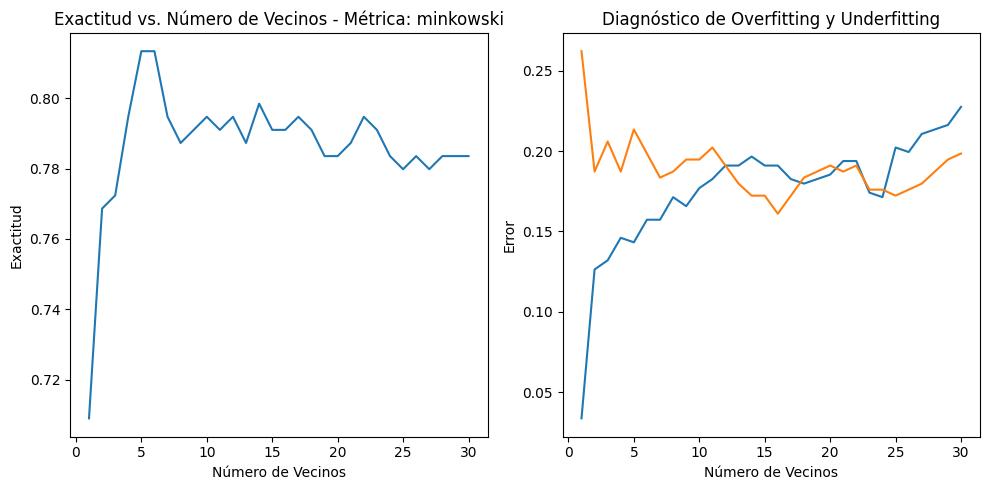

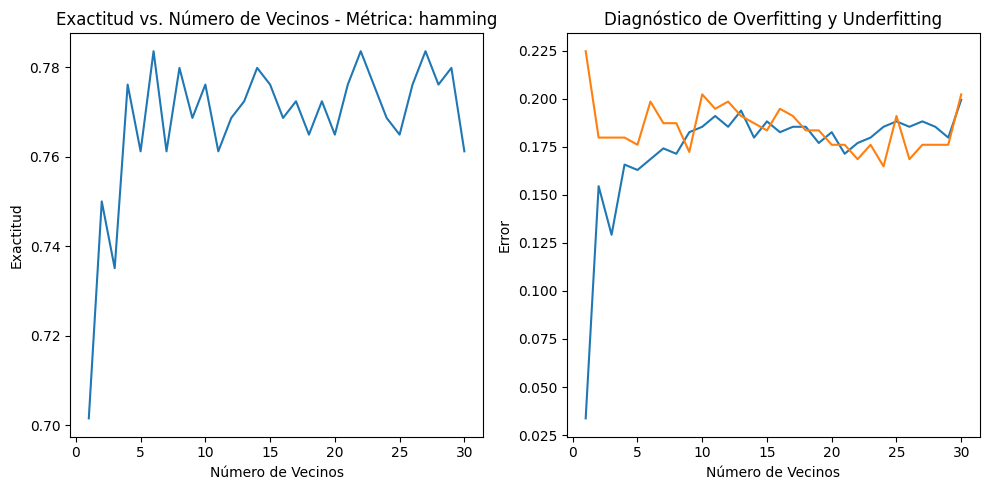

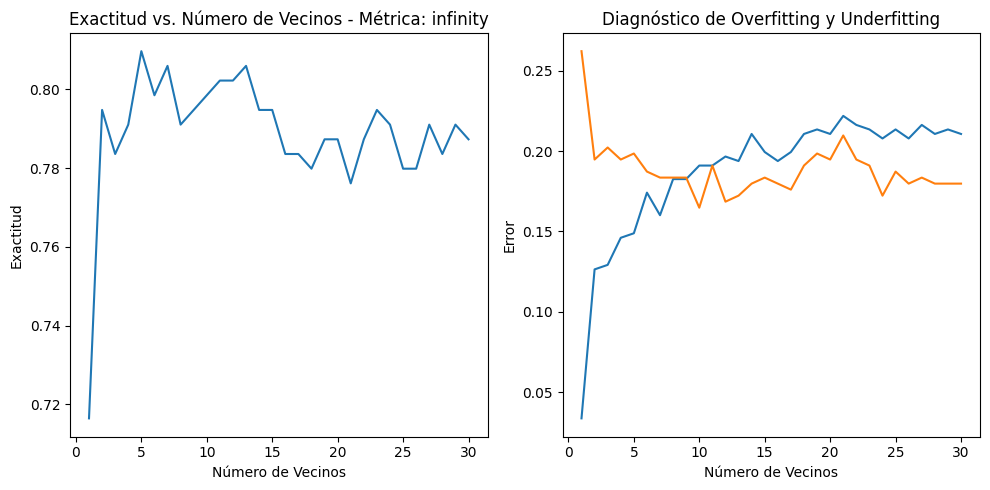

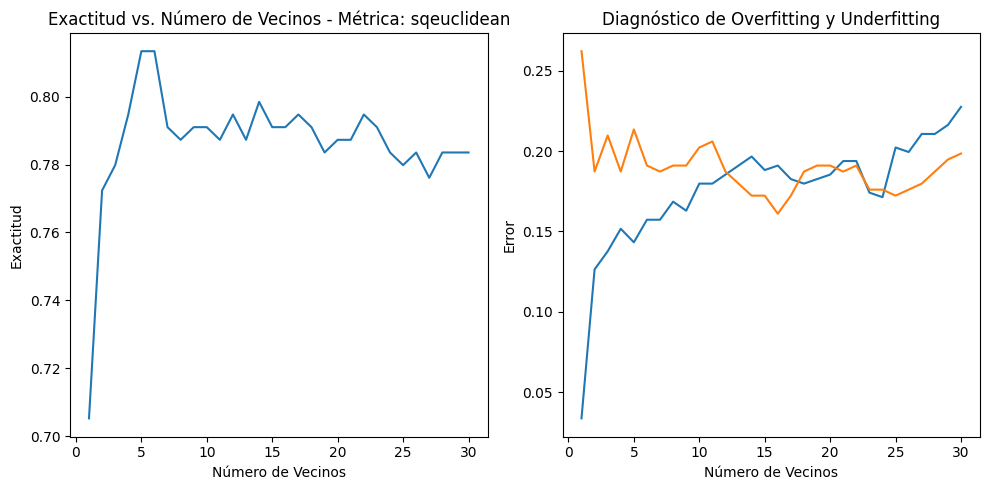

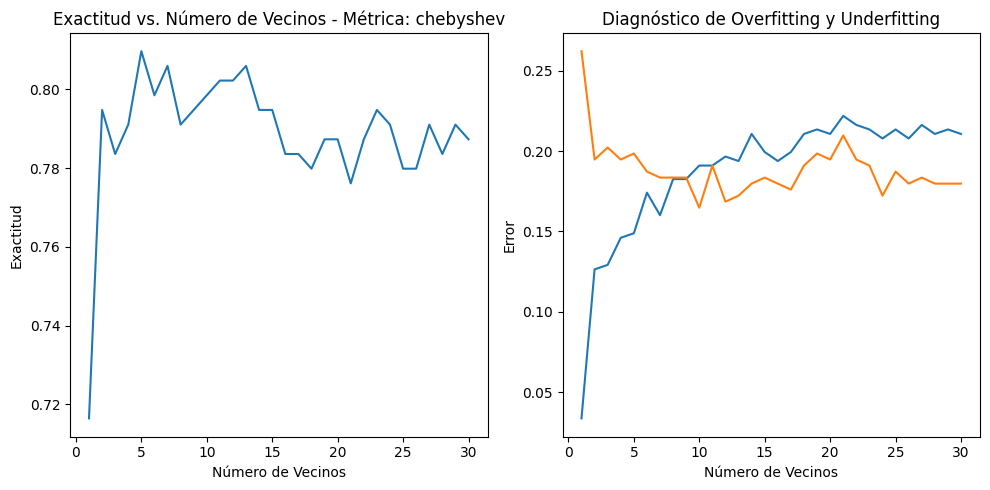

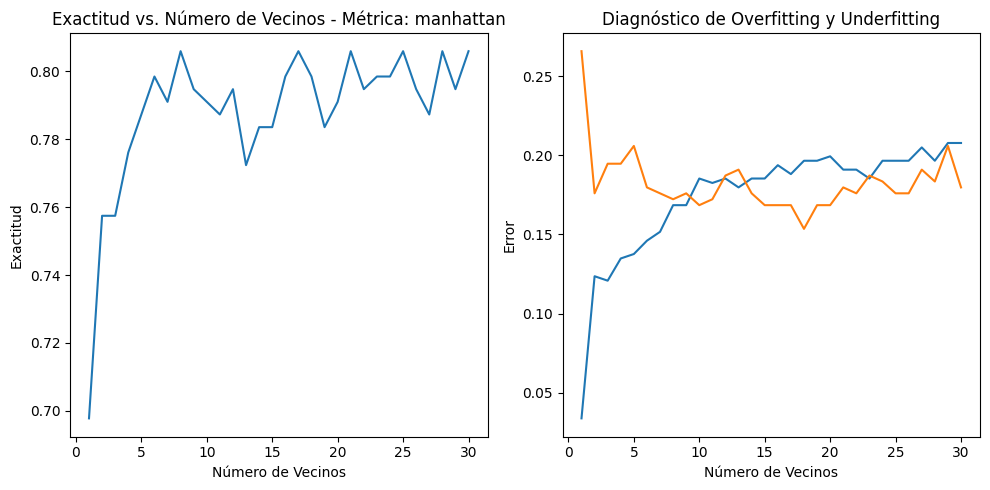

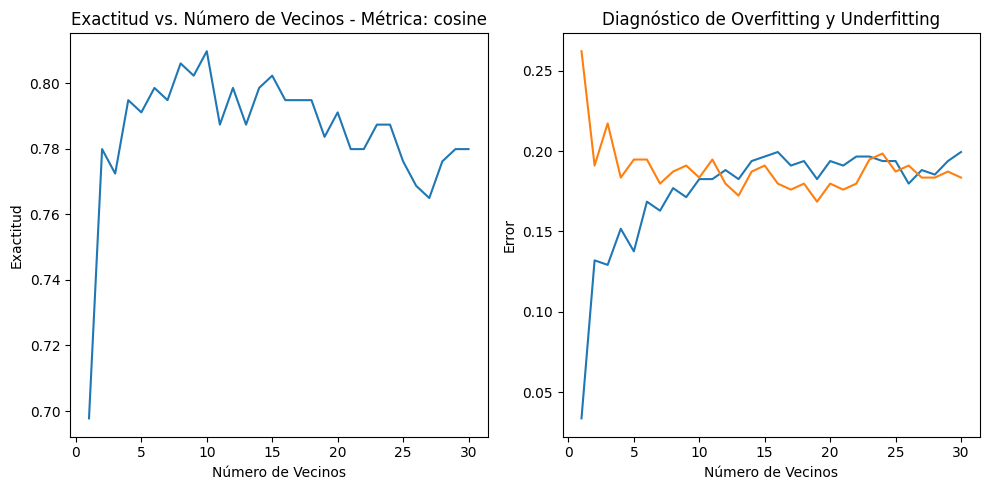

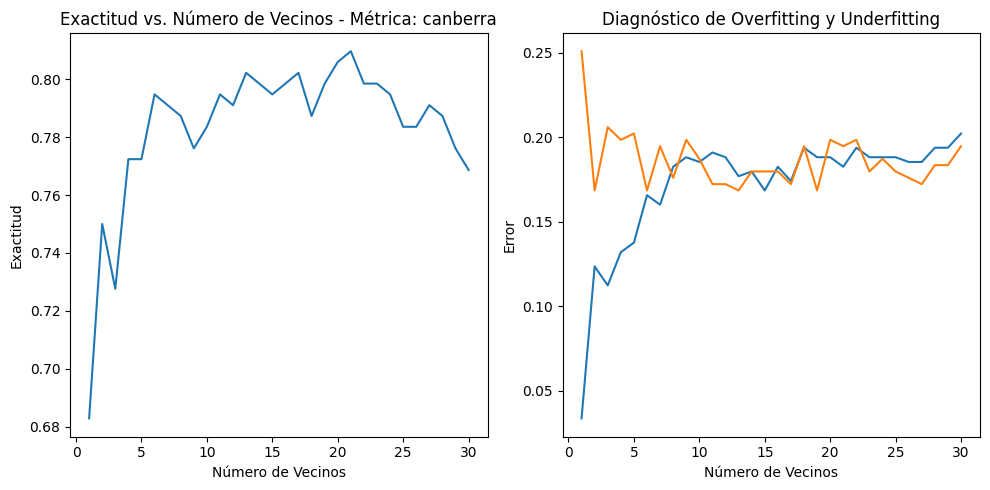

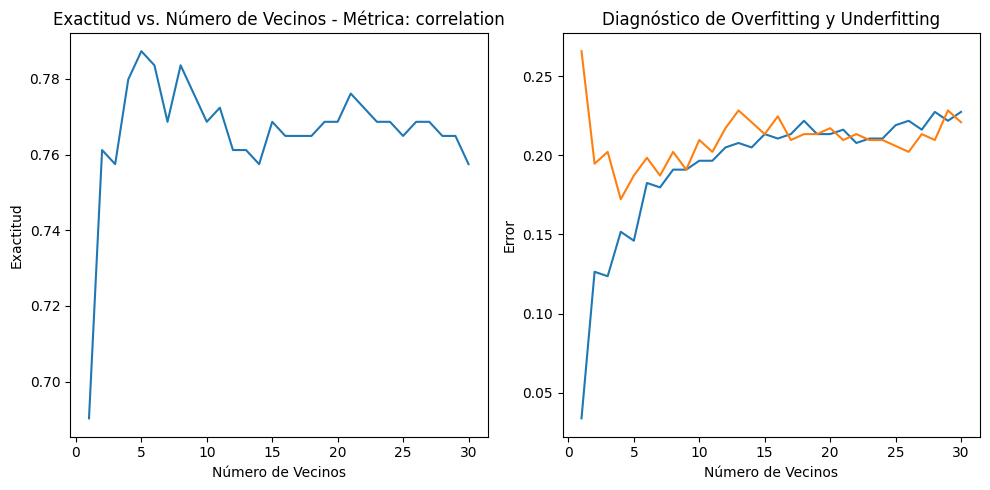

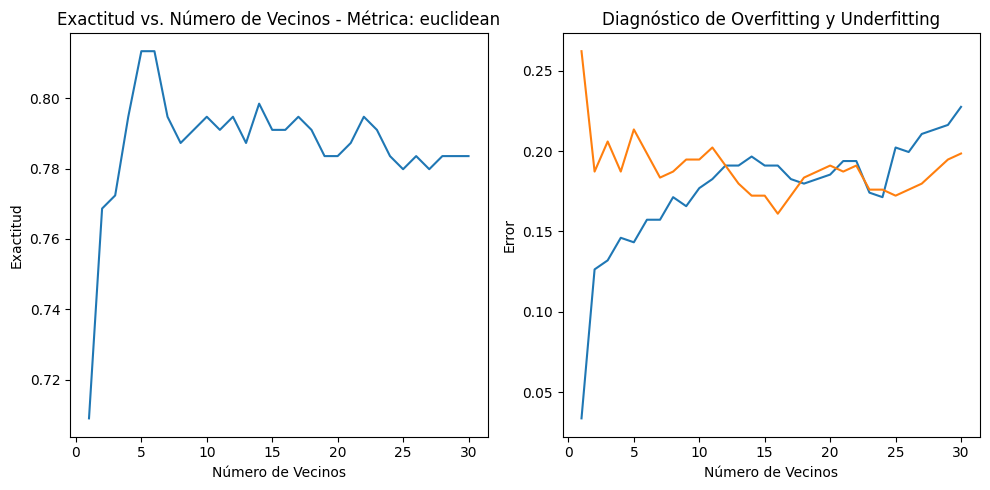

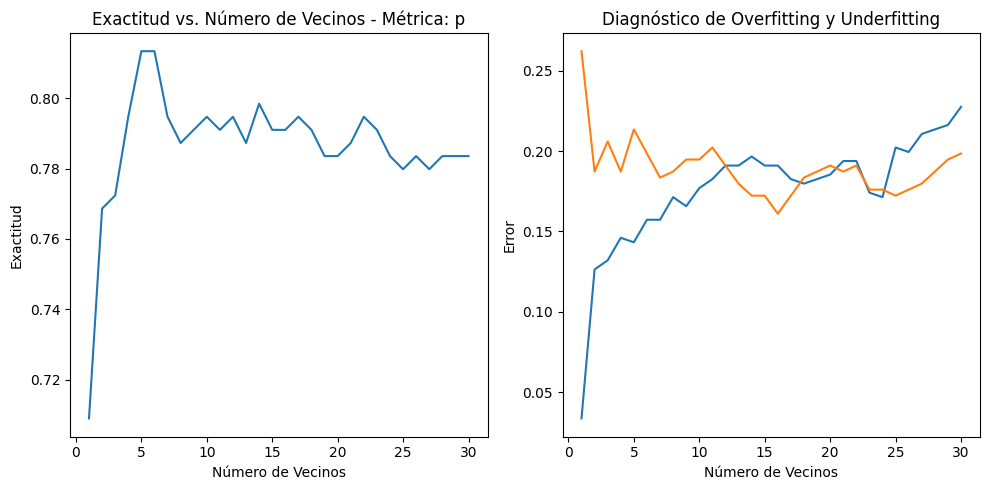

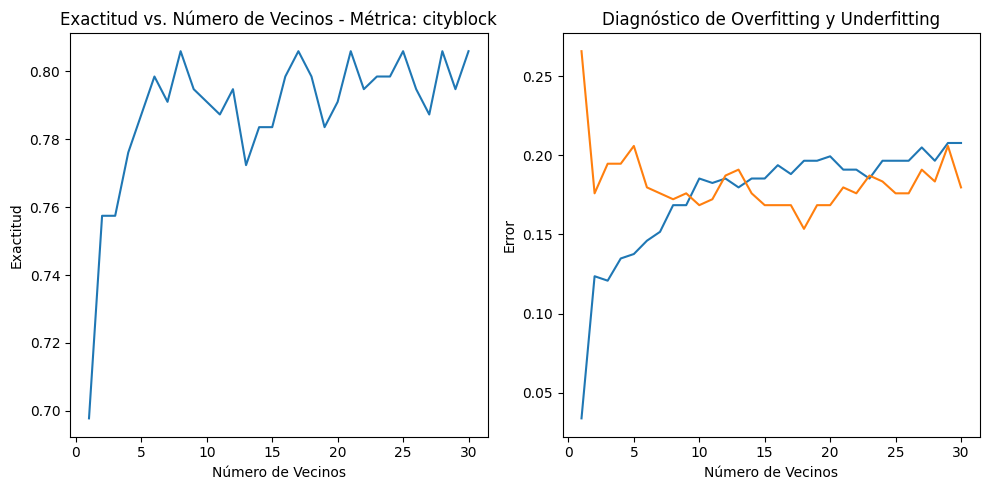

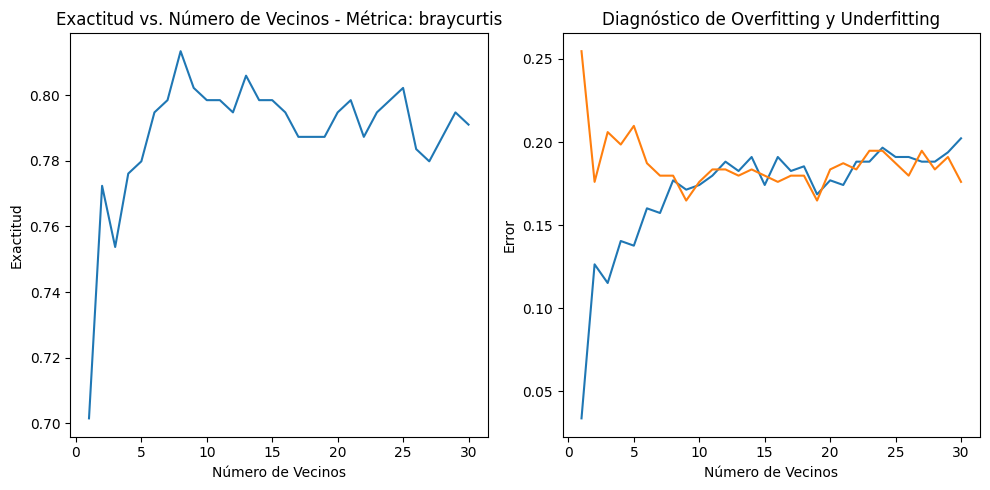

In [ ]:
# Definir una funcion para entrenar y evaluar el modelo
def train_and_evaluate_model(X_train, y_train, X_test, y_test, metrica, n_range):
    accuracy_array = []
    train_errors = []
    val_errors = []

    for i in n_range:
        classifier = KNeighborsClassifier(n_neighbors=i, metric=metrica)
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        # Predecir en el conjunto de entrenamiento y validación
        y_train_pred = classifier.predict(X_train)
        y_val_pred = classifier.predict(X_val)

        accuracy_score_temp = accuracy_score(y_test, y_pred)

        # Calcular el error y almacenarlo
        train_error = 1 - accuracy_score(y_train, y_train_pred)
        val_error = 1 - accuracy_score(y_val, y_val_pred)

        accuracy_array.append(accuracy_score_temp)
        train_errors.append(train_error)
        val_errors.append(val_error)

    return accuracy_array, train_errors, val_errors

# Lista de metricas de distancia a probar
metricas_distancia = ['minkowski', 'hamming', 'infinity', 'sqeuclidean', 'chebyshev', 'manhattan', 'cosine', 'canberra', 'correlation', 'euclidean', 'p', 'cityblock', 'braycurtis']

# Estimación del valor de k
k = int(math.sqrt(len(y_test))*2)
if k % 2 == 0:
  k = k - 1
n_range = list(range(1, k))

# Lista para almacenar los resultados de las métricas
metricas_modelo = []
max_accuracy_dict = {}

# Evaluar el modelo para cada metrica de distancia
for metrica in metricas_distancia:
    accuracy_array, train_errors, val_errors = train_and_evaluate_model(X_train, y_train, X_test, y_test, metrica, n_range)
    metricas_modelo.append([accuracy_array, train_errors, val_errors])

# Procesar los resultados y generar graficos
for metrica, metrica_data in zip(metricas_distancia, metricas_modelo):
    accuracy_scores, train_errors, val_errors = metrica_data

    max_accuracy = max(accuracy_scores)
    best_k = n_range[accuracy_scores.index(max_accuracy)]

    max_accuracy_dict[metrica] = {'max_accuracy': max_accuracy, 'best_k': best_k}

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_range, accuracy_scores)
    plt.xlabel('Número de Vecinos')
    plt.ylabel('Exactitud')
    plt.title(f'Exactitud vs. Número de Vecinos - Métrica: {metrica}')

    plt.subplot(1, 2, 2)
    plt.plot(n_range, train_errors, label='Error en Entrenamiento')
    plt.plot(n_range, val_errors, label='Error en Validación')
    plt.xlabel('Número de Vecinos')
    plt.ylabel('Error')
    plt.title('Diagnóstico de Overfitting y Underfitting')

    plt.tight_layout()
    plt.show()

# Crear un DataFrame a partir del diccionario de resultados
df = pd.DataFrame.from_dict(max_accuracy_dict, orient='index')
df.index.name = 'metric'
df.reset_index(inplace=True)
df.rename(columns={'max_accuracy': 'max_acuraccy', 'best_k': 'k_value'}, inplace=True)


## Análisis de desempeño
A continuación se presentan los resultados de exactitud para cada configuración con su valor de k correspondiente.

In [ ]:
# Imprimir el DataFrame ordenado por resultados
sorted_df = df.sort_values(by=['max_acuraccy', 'k_value'], ascending=[False, True])
sorted_df

,metric,max_acuraccy,k_value
0,minkowski,0.813433,5
3,sqeuclidean,0.813433,5
9,euclidean,0.813433,5
10,p,0.813433,5
12,braycurtis,0.813433,8
2,infinity,0.809701,5
4,chebyshev,0.809701,5
6,cosine,0.809701,10
7,canberra,0.809701,21
5,manhattan,0.805970,8
